## 규제 선형 모델 실습: 보스톤 주택가격 예측

### 모듈 임포트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### 데이터 준비

In [5]:
boston_df = pd.read_csv('data/boston.csv')
print(f'데이터 크기: {boston_df.shape}')
boston_df.head()

데이터 크기: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


- CRIM: 지역별 범죄 발생률
- ZN: 25,000평방피트를 초과하는 거주 지역의 비율
- INDUS: 비상업 지역 넓이 비율
- CHAS: 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
- NOX: 일산화질소 농도
- RM: 거주할 수 있는 방 개수
- AGE: 1940년 이전에 건축된 소유 주택의 비율
- DIS: 5개 주요 고용센터까지의 가중 거리
- RAD: 고속도로 접근 용이도
- TAX: 10,000달러당 재산세율
- PTRATIO: 지역의 교사와 학생 수 비율
- B: 지역의 흑인 거주 비율
- LSTAT: 하위 계층의 비율
- MEDV: 본인 소유의 주택 가격(중앙값)
- price: 주택 가격

### 데이터 탐색

In [6]:
boston_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


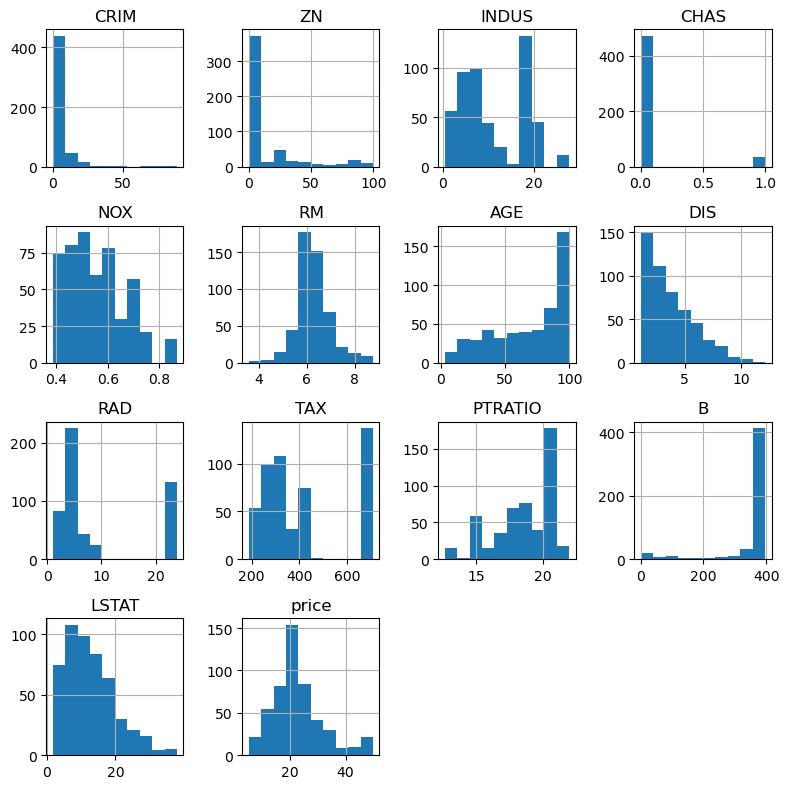

In [8]:
boston_df.hist(figsize=(8,8))
plt.tight_layout()
plt.show()

In [9]:
skews = []
kurt = []
for ftr in boston_df.columns:
    skews.append(boston_df[ftr].skew())
    kurt.append(boston_df[ftr].kurt())

desc_df = boston_df.describe().T
desc_df['skewness']=skews
desc_df['kurtosis']=kurt
desc_df[['skewness','kurtosis']]

,skewness,kurtosis
CRIM,5.223149,37.130509
ZN,2.225666,4.031510
INDUS,0.295022,-1.233540
CHAS,3.405904,9.638264
NOX,0.729308,-0.064667
RM,0.403612,1.891500
AGE,-0.598963,-0.967716
DIS,1.011781,0.487941
RAD,1.004815,-0.867232
TAX,0.669956,-1.142408


In [10]:
ftr_names = boston_df.columns.difference(['price','CHAS'])
ftr_names

Index(['AGE', 'B', 'CRIM', 'DIS', 'INDUS', 'LSTAT', 'NOX', 'PTRATIO', 'RAD',
       'RM', 'TAX', 'ZN'],
      dtype='object')

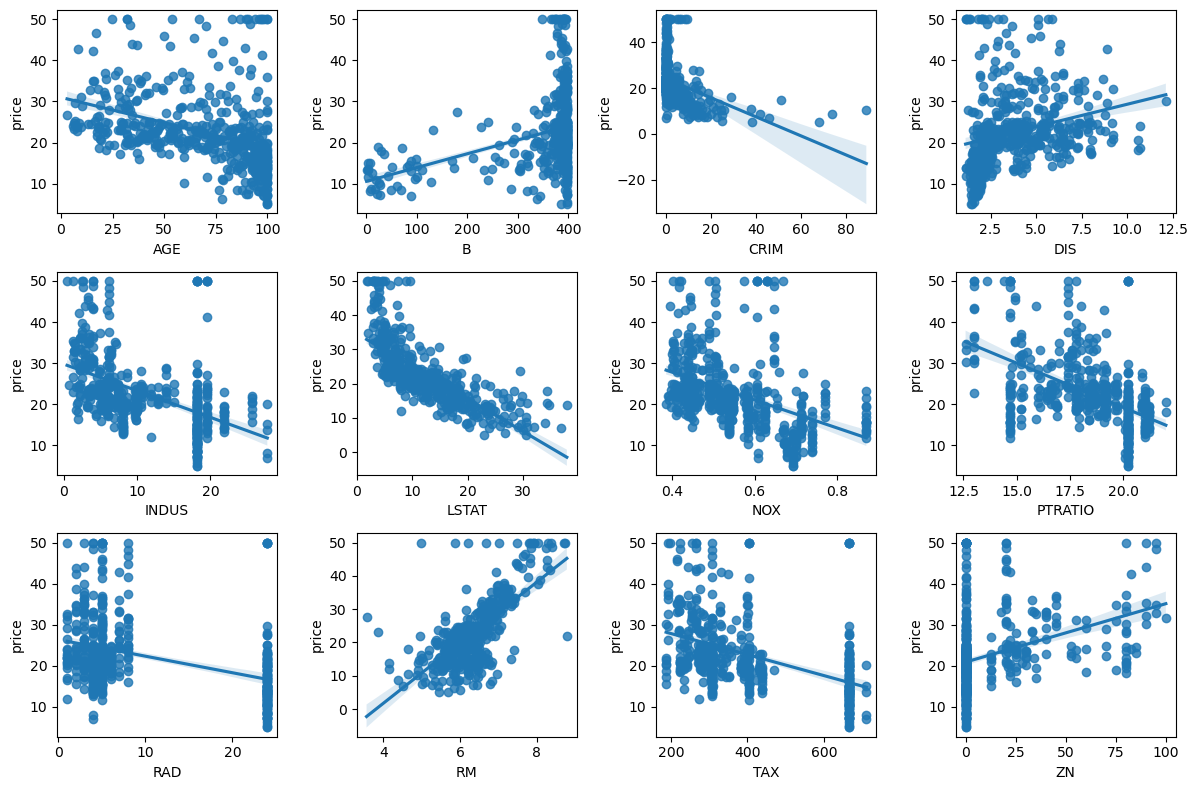

In [11]:
fig, ax = plt.subplots(figsize=(12,8), nrows=3, ncols=4)
for i, ftr in enumerate(ftr_names):
    row, col = i//4, i%4
    sns.regplot(x= ftr, y= 'price', data= boston_df, ax=ax[row][col])
plt.tight_layout()
plt.show()

In [12]:
def correlation_heatmap(df):
    corr = df.corr()
    cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    mask = np.zeros_like(corr, dtype=np.bool_)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(12,12))
    sns.heatmap(corr, annot=True, mask=mask, cmap=cmap,
                linewidths=.5, fmt='.2f', annot_kws={'size':8})
    plt.show()

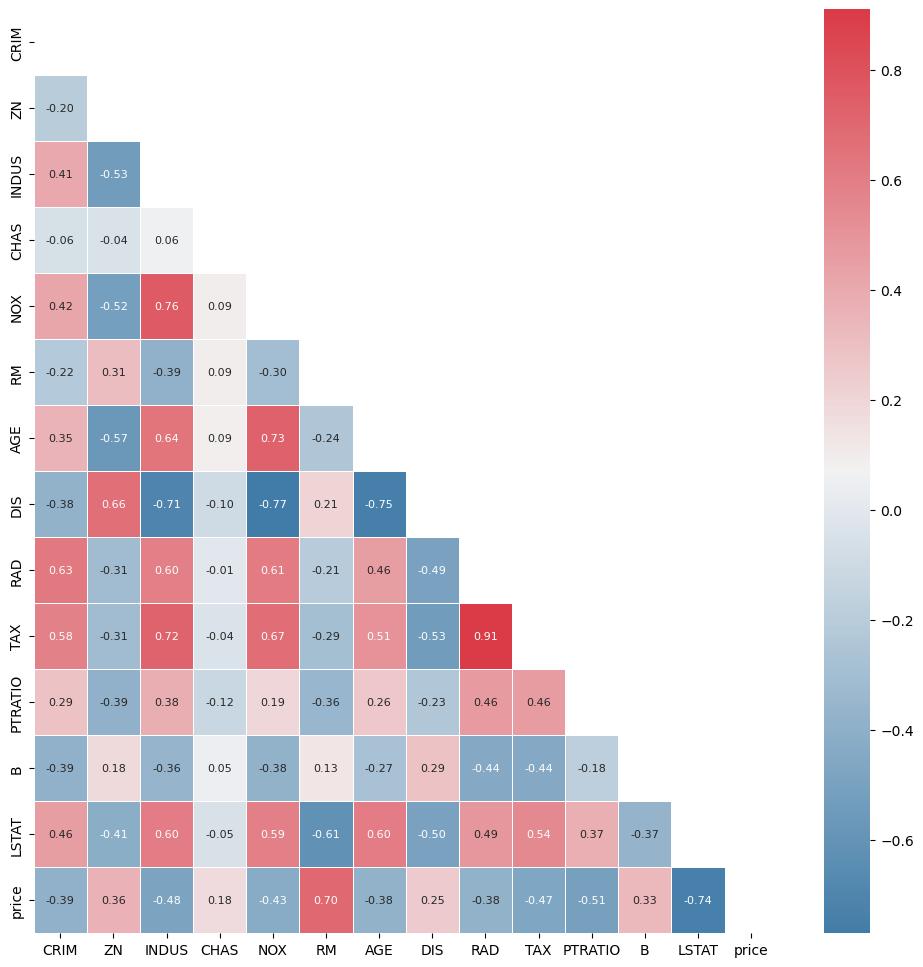

In [13]:
correlation_heatmap(boston_df)

In [20]:
from scipy import stats

def pearson_corr(df):
    ftr_names = df.columns.difference(['price','CHAS'])
    
    coef_list = []
    p_list = []
    for col in ftr_names:
        coef, p = stats.pearsonr(df.price, df[col])
        coef_list.append(np.round(coef, 4))
        p_list.append(p)
    
    corr_df = pd.DataFrame({'pearson_coef': coef_list, 'p_value': p_list}, 
                 index=ftr_names).sort_values('pearson_coef', ascending=False)
    return corr_df

In [21]:
pearson_corr(boston_df)

,pearson_coef,p_value
RM,0.6954,2.487229e-74
ZN,0.3604,5.713584e-17
B,0.3335,1.318113e-14
DIS,0.2499,1.206612e-08
AGE,-0.3770,1.569982e-18
RAD,-0.3816,5.465933e-19
CRIM,-0.3883,1.173987e-19
NOX,-0.4273,7.065042e-24
TAX,-0.4685,5.637734e-29
INDUS,-0.4837,4.900260e-31


In [38]:
# 회귀계수 시각화
def reg_coef_plot(model, ftr_names):
    coef = pd.Series(data=np.round(model.coef_,1), index=ftr_names).sort_values(ascending=False)
    print(f'회귀계수:\n{coef}')
    sns.barplot(x=coef, y=coef.index)
    plt.show()

# 잔차 출력 및 상위 n개 추출
def get_residual(y_test, y_pred, top_n=10):
    residual = y_test - y_pred
    df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 
                       'residual': residual, 'abs(resid)':np.abs(residual)})
    top = df.sort_values('abs(resid)',ascending=False)[:top_n]
    return top

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean((log_y - log_pred)**2))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# 회귀모델 성능 평가를 위한 함수 작성(MSE, RMSE, RMSLE, MAE, R2 계산)
def eval_regr_scores(y, pred, is_log=False):
    mse_ = mean_squared_error(y, pred)
    rmse_ = rmse(y, pred)
    rmsle_ = rmsle(y, pred)
    mae_ = mean_absolute_error(y, pred)
    r2_ = r2_score(y, pred)

    print(f'R_square: {r2_:.3f}')
    print(f'RMSE: {rmse_:.2f}')
    if is_log:
        print(f'RMSLE: {rmsle_:.2f}')
    print(f'MSE: {mse_:.2f}, MAE: {mae_:.2f}')

# 회귀모델 학습/예측/성능평가
def get_modeling_predict(model,x,y, is_log=False):
    # 학습/테스트 데이터 분할
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=156)
    # 학습
    model.fit(x_train, y_train)
    # 예측
    y_pred = model.predict(x_test)
    # 평가결과 출력
    if is_log:
        y_test, y_pred = np.expm1(y_test), np.expm1(y_pred)
        text = 'log변환'
    else:
        text = ''
    print(f'## {model.__class__.__name__} {text} ##')
    eval_regr_scores(y_test, y_pred, is_log=is_log)
    return model

### 일반 선형 모델 : LinearRegression()

In [24]:
x = boston_df.drop('price', axis=1)
y = boston_df.price

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,
                                                   random_state=156)
lr = LinearRegression() 
get_modeling_predict(lr ,x,y, is_log=False)

## LinearRegression  ##
R_square: 0.785
RMSE: 4.26
MSE: 18.14, MAE: 3.27


LinearRegression()

회귀계수:
RM          3.4
CHAS        2.8
RAD         0.3
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.5
PTRATIO    -0.9
DIS        -1.6
NOX       -20.1
dtype: float64


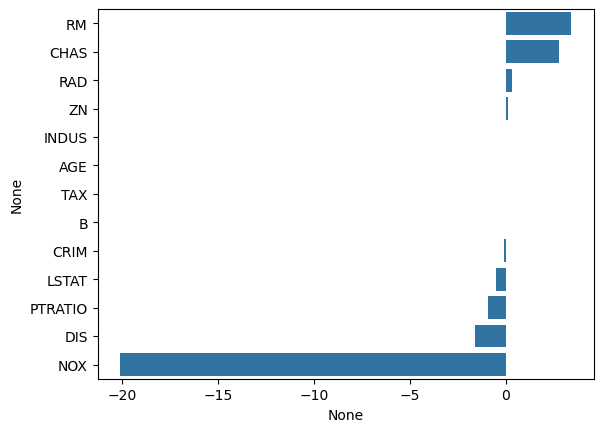

In [32]:
reg_coef_plot(lr, x.columns)

#### Linear Regression의 교차검증

In [41]:
lr2 = LinearRegression()
neg_mse = cross_val_score(lr2, x,y, cv=5, scoring='neg_mean_squared_error')
rmse_val = np.sqrt(neg_mse*(-1))
avg_rmse = np.mean(rmse_val)
print(f'RMSE: {np.round(rmse_val,3)}')
print(f'AVG_RMSE: {np.round(avg_rmse,3)}')

RMSE: [3.53  5.104 5.751 8.987 5.772]
AVG_RMSE: 5.829


## 1. 릿지 회귀모델

#### 릿지 회귀 모델 정의

In [42]:
ridge = Ridge(alpha=10)

ridge = get_modeling_predict(ridge ,x,y, is_log=False)

## Ridge  ##
R_square: 0.787
RMSE: 4.25
MSE: 18.04, MAE: 3.17


-- LinearRegression -- <br>
R_square: 0.785, RMSE: 4.26, MSE: 18.14, MAE: 3.27

-- Ridge(alpha=10) -- <br>
R_square: 0.787, RMSE: 4.25, MSE: 18.04, MAE: 3.17

회귀계수:
RM         3.4
CHAS       1.7
RAD        0.3
ZN         0.1
INDUS     -0.0
AGE       -0.0
TAX       -0.0
B          0.0
CRIM      -0.1
LSTAT     -0.6
PTRATIO   -0.7
DIS       -1.4
NOX       -2.2
dtype: float64


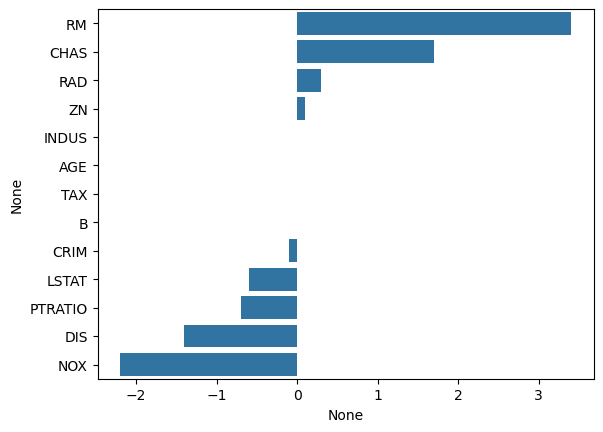

In [43]:
reg_coef_plot(ridge, x.columns)

#### 교차검증으로 모델 평가
cross_val_score() 사용

In [44]:
ridge2 = Ridge(alpha=10)
neg_mse2 = cross_val_score(ridge, x,y, cv=5, scoring='neg_mean_squared_error')
rmse_val2 = np.sqrt(neg_mse2*(-1))
avg_rmse2 = np.mean(rmse_val2)
print(f'-- {ridge2.__class__.__name__} alpha=10 --')
print(f'RMSE: {np.round(rmse_val2,3)}')
print(f'AVG_RMSE: {np.round(avg_rmse2,3)}')

-- Ridge alpha=10 --
RMSE: [3.38  4.929 5.305 8.637 5.34 ]
AVG_RMSE: 5.518


-- LinearRegression -- <br>
RMSE: [3.53  5.104 5.751 8.987 5.772], AVG_RMSE: 5.829

-- Ridge(alpha=10) -- <br>
RMSE: [3.38  4.929 5.305 8.637 5.34 ], 
AVG_RMSE: 5.518

In [49]:
# 회귀분석에서는 scoring을 대부분 'neg_mean_squared_error'로 사용
def reg_model_cv_training(model, x, y, cv=5, scoring='neg_mean_squared_error', alpha=None):
    neg_mse = cross_val_score(model, x,y, cv= cv, scoring= scoring)
    rmse = np.sqrt(neg_mse*(-1))
    avg_rmse = np.mean(rmse)
    if alpha:
        text = 'alpha='+ str(alpha)
    else:
        text= ''
    print(f'-- {model.__class__.__name__} {text}의 {cv}폴드 교차검증 --')
    print(f'RMSE: {np.round(rmse,3)}, AVG_RMSE: {np.round(avg_rmse,3)}')

In [47]:
reg_model_cv_training(ridge2, x, y)

-- Ridge 의 5폴드 교차검증 --
RMSE: [3.38  4.929 5.305 8.637 5.34 ], AVG_RMSE: 5.518


In [50]:
reg_model_cv_training(lr,x,y)

-- LinearRegression 의 5폴드 교차검증 --
RMSE: [3.53  5.104 5.751 8.987 5.772], AVG_RMSE: 5.829


### Ridge() 모델에서 alpha를 다르게 준 경우

#### alpha를 0 , 0.1 , 1 , 10 , 100으로 다르게 준 경우 RMSE

In [56]:
alphas = [0 , 0.1 , 1 , 10 , 100]
for alpha in alphas:
    model = Ridge(alpha=alpha)
    reg_model_cv_training(model,x,y, alpha=alpha)
    print()

-- Ridge 의 5폴드 교차검증 --
RMSE: [3.53  5.104 5.751 8.987 5.772], AVG_RMSE: 5.829

-- Ridge alpha=0.1의 5폴드 교차검증 --
RMSE: [3.51  5.02  5.695 8.983 5.734], AVG_RMSE: 5.788

-- Ridge alpha=1의 5폴드 교차검증 --
RMSE: [3.422 4.856 5.449 8.957 5.578], AVG_RMSE: 5.653

-- Ridge alpha=10의 5폴드 교차검증 --
RMSE: [3.38  4.929 5.305 8.637 5.34 ], AVG_RMSE: 5.518

-- Ridge alpha=100의 5폴드 교차검증 --
RMSE: [3.581 5.223 5.889 7.259 4.696], AVG_RMSE: 5.33



#### 각 alpha에 따른 Ridge 모델의 회귀 계수 값 시각화

In [59]:
coef_df = pd.DataFrame(index = x.columns)

alphas = [0 , 0.1 , 1 , 10 , 100]
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(x_train,y_train)
    coef_df[f'alpha= {alpha}'] = model.coef_
coef_df

,alpha= 0,alpha= 0.1,alpha= 1,alpha= 10,alpha= 100
CRIM,-0.112980,-0.111481,-0.104512,-0.099000,-0.102114
ZN,0.065512,0.065924,0.067969,0.071585,0.077112
INDUS,0.034437,0.027613,-0.004488,-0.035874,-0.032625
CHAS,3.045898,3.017620,2.829321,1.950964,0.534112
NOX,-19.795832,-18.169376,-10.439966,-1.970719,-0.199094
RM,3.354969,3.363543,3.391832,3.200516,1.851314
AGE,0.005937,0.004657,-0.001298,-0.005656,0.007212
DIS,-1.741854,-1.717137,-1.599770,-1.467848,-1.296977
RAD,0.355884,0.352073,0.334592,0.324520,0.351072
TAX,-0.014295,-0.014423,-0.015059,-0.016184,-0.017610


**alpha 값에 따른 컬럼별 회귀계수 출력**

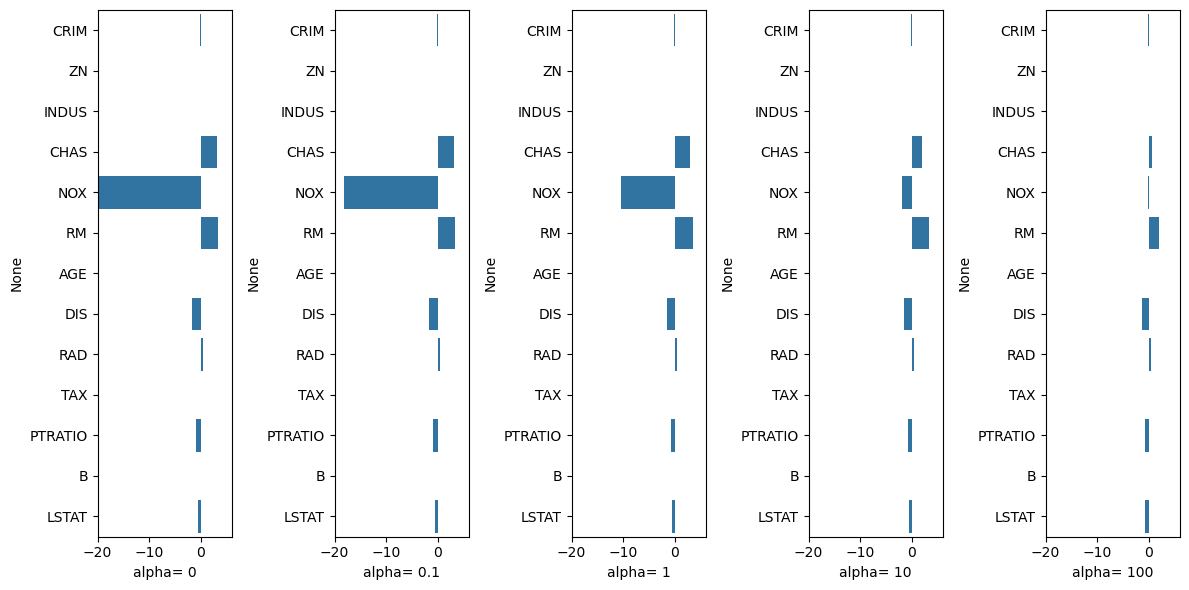

In [62]:
fig, ax = plt.subplots(figsize=(12,6), ncols=5)

for i, col in enumerate(coef_df.columns):
    ax[i].set_xlim(-20,6)
    sns.barplot(data=coef_df, x=coef_df[col], y = coef_df.index, ax = ax[i])
plt.tight_layout()
plt.show()

=> Ridge 모델은 alpha의 값이 커질수록 회귀계수의 값이 줄어드며, RMSE값도 줄어든다.

### 규제가 있는 회귀모델 적용 함수 get_linear_reg_eval() 작성
- 매개변수로 규제회귀 Ridge, Lasso, ElasticNet을 지정하여 해당 규제 모델을 학습하고 예측성능 출력

In [100]:
def get_linear_reg_eval(model_name, x, y, feature_names, verbose=True, params=None, return_coef=True):
    coef_df = pd.DataFrame(index = feature_names)
    if verbose:
        print(f'-- {model_name} --')
    for param in params:
        if model_name == 'Ridge':
            model = Ridge(alpha=param)
        elif model_name == 'Lasso':
            model = Lasso(alpha=param)
        elif model_name == 'ElasticNet':
            model = ElasticNet(alpha= param, l1_ratio=0.7)
            
        reg_model_cv_training(model,x,y, alpha=param)
        print('-----------------------')
        model.fit(x,y)
        if return_coef:
            coef_df[f'alpha= {param}'] = model.coef_
    return coef_df

In [72]:
get_linear_reg_eval('Ridge', x, y, feature_names=x.columns, params=[5,10,20])

-- Ridge --
-- Ridge alpha=5의 5폴드 교차검증 --
RMSE: [3.372 4.898 5.292 8.815 5.431], AVG_RMSE: 5.562
-----------------------
-- Ridge alpha=10의 5폴드 교차검증 --
RMSE: [3.38  4.929 5.305 8.637 5.34 ], AVG_RMSE: 5.518
-----------------------
-- Ridge alpha=20의 5폴드 교차검증 --
RMSE: [3.409 4.974 5.39  8.334 5.198], AVG_RMSE: 5.461
-----------------------


,alpha= 5,alpha= 10,alpha= 20
CRIM,-0.101799,-0.101435,-0.101650
ZN,0.048783,0.049579,0.050683
INDUS,-0.035897,-0.042962,-0.047200
CHAS,2.229483,1.952021,1.573044
NOX,-4.185995,-2.371619,-1.269559
RM,3.812647,3.702272,3.479459
AGE,-0.010329,-0.010707,-0.009449
DIS,-1.275862,-1.248808,-1.229852
RAD,0.278791,0.279596,0.285442
TAX,-0.013623,-0.013993,-0.014447


## 2. 라쏘 회귀모델

### Lasso 회귀 모델 정의 및 모델 평가
- cross_val_score()
- 라쏘 모델의 alpha값 변경

#### get_linear_reg_eval()함수를 사용하여 라쏘모델의 성능 평가

: alpha값을 0.07, 0.1, 0.5, 1, 3으로 지정한 경우 

In [74]:
coef_df_l = get_linear_reg_eval('Lasso', x, y, feature_names=x.columns, params=[0.07,0.1,0.5,1,3,5])

-- Lasso --
-- Lasso alpha=0.07의 5폴드 교차검증 --
RMSE: [3.342 4.938 5.342 8.972 5.468], AVG_RMSE: 5.612
-----------------------
-- Lasso alpha=0.1의 5폴드 교차검증 --
RMSE: [3.35  4.934 5.425 8.909 5.458], AVG_RMSE: 5.615
-----------------------
-- Lasso alpha=0.5의 5폴드 교차검증 --
RMSE: [3.531 5.253 6.5   8.197 4.865], AVG_RMSE: 5.669
-----------------------
-- Lasso alpha=1의 5폴드 교차검증 --
RMSE: [3.891 5.773 7.3   7.524 4.392], AVG_RMSE: 5.776
-----------------------
-- Lasso alpha=3의 5폴드 교차검증 --
RMSE: [4.77  6.074 8.462 7.249 4.39 ], AVG_RMSE: 6.189
-----------------------
-- Lasso alpha=5의 5폴드 교차검증 --
RMSE: [5.029 6.358 8.621 7.523 4.346], AVG_RMSE: 6.375
-----------------------


**alpha값에 따른 피처별 회귀 계수**

In [82]:
coef_df_l

,alpha= 0.07,alpha= 0.1,alpha= 0.5,alpha= 1,alpha= 3,alpha= 5
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000,-0.000000
ZN,0.049059,0.049211,0.049544,0.049165,0.037231,0.038467
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000,-0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000,0.000000
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
RM,3.789725,3.703202,2.498212,0.949811,0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495,0.031679
DIS,-1.176583,-1.160538,-0.936605,-0.668790,-0.000000,-0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864,0.000000
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602,-0.007669


#### 각 alpha에 따른 Lasso 회귀 계수 값을 시각화

In [96]:
def coefficients_plot(coef_df):
    ncols = coef_df.shape[1]
    coef_max = round(coef_df.max().max())
    coef_min = round(coef_df.min().min())
    fig, ax = plt.subplots(figsize=(12,6), ncols=ncols)
    
    for i, col in enumerate(coef_df.columns):
        ax[i].set_xlim(coef_min, coef_max)
        sort_coef = coef_df[col].sort_values(ascending=False)
        sns.barplot(x=sort_coef, y = sort_coef.index, ax = ax[i])
    plt.tight_layout()
    plt.show()

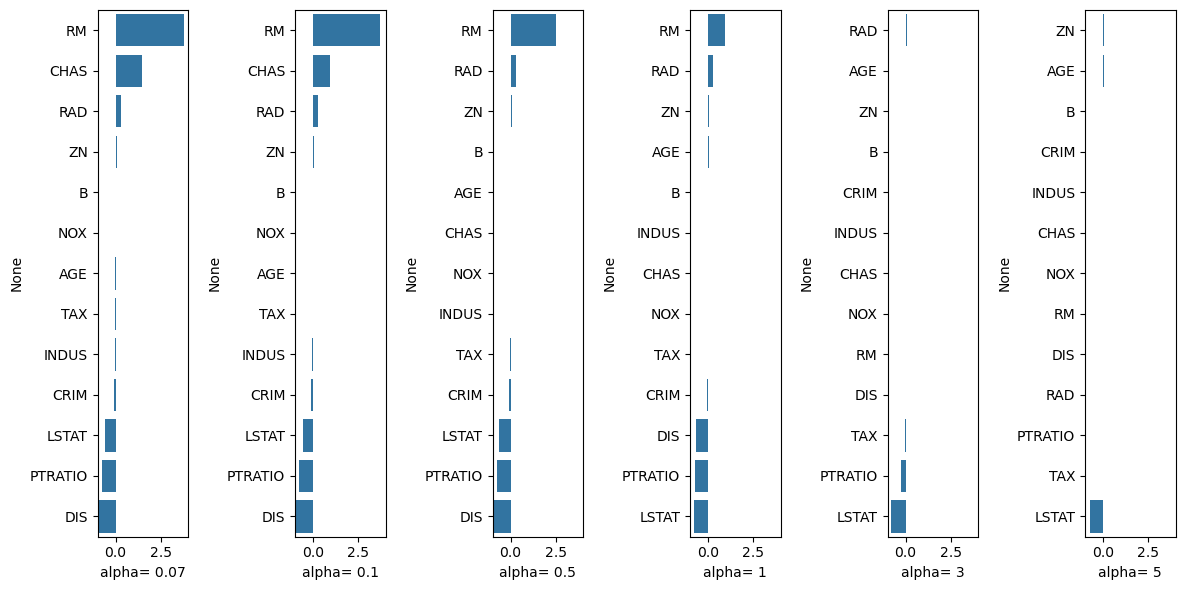

In [97]:
coefficients_plot(coef_df_l)

=> Lasso 모델의 alpha값이 커지면 회귀계수의 값이 0이 되는 피처가 늘어남

## 3. 엘라스틱넷 회귀 모델

#### 엘라스틱넷에 사용될 alpha값을 변화시키면서 성능평가

In [101]:
elastic_alpha = [0.07,0.1,0.5,1,3]
coef_elastic = get_linear_reg_eval('ElasticNet', x, y, feature_names=x.columns,
                                params=elastic_alpha)

-- ElasticNet --
-- ElasticNet alpha=0.07의 5폴드 교차검증 --
RMSE: [3.376 4.961 5.385 8.659 5.327], AVG_RMSE: 5.542
-----------------------
-- ElasticNet alpha=0.1의 5폴드 교차검증 --
RMSE: [3.392 4.977 5.477 8.523 5.26 ], AVG_RMSE: 5.526
-----------------------
-- ElasticNet alpha=0.5의 5폴드 교차검증 --
RMSE: [3.625 5.309 6.378 7.394 4.628], AVG_RMSE: 5.467
-----------------------
-- ElasticNet alpha=1의 5폴드 교차검증 --
RMSE: [3.862 5.587 7.133 7.012 4.391], AVG_RMSE: 5.597
-----------------------
-- ElasticNet alpha=3의 5폴드 교차검증 --
RMSE: [4.606 5.967 8.269 7.131 4.368], AVG_RMSE: 6.068
-----------------------


#### alpha값에 따른 엘라스틱넷 회귀계수

In [102]:
coef_elastic

,alpha= 0.07,alpha= 0.1,alpha= 0.5,alpha= 1,alpha= 3
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000
RM,3.574162,3.414154,1.918419,0.938789,0.000000
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
DIS,-1.189438,-1.173647,-0.975902,-0.725174,-0.031208
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417


#### l1_ratio=0.7로 고정하고, alpha에 따른 ElasticNet 회귀 계수 값을 시각화

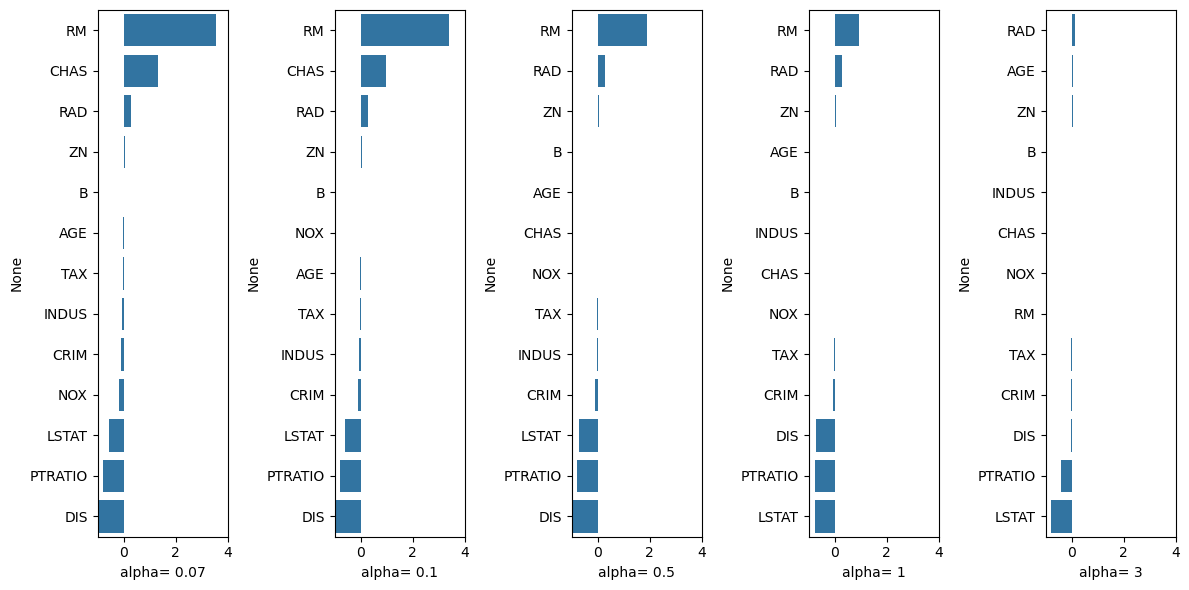

In [103]:
coefficients_plot(coef_elastic)

-------------------------------------------------